In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
print(tf.__version__)

2.10.0


In [2]:
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9441221491995104358
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1749391771
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13987873387724538577
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [ ]:

WIDTH = 120
HEIGHT = 120
CHANNEL = 1
model_name = "model_2000.h5"
##save edilecek modelin ismini aşağıdan ayarla

In [3]:
os.chdir("./dataset")
image_list = os.listdir()
print("example : ",image_list[0:5])

example :  ['image_1000_999.jpg', 'image_1001_1000.jpg', 'image_1002_1001.jpg', 'image_1003_1002.jpg', 'image_1004_1003.jpg']


In [4]:
def import_the_photos_from_names(list_of_photo_names,WIDTH,HEIGHT):
    #isimlerinden fotoğrafları içeri aktar
    photos = []
    sayac = 1
    for im in list_of_photo_names:
        im = np.array(Image.open(im).resize((WIDTH,HEIGHT)))
        #print("importing image: ",sayac)
        sayac+=1
        photos.append(im)
    print("images are imported , length of images : ", len(photos))
    return photos

def onehot_labels(values):
    from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded),1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded


x_data = import_the_photos_from_names(image_list,WIDTH,HEIGHT)
x_data = np.array(x_data)
x_data = (x_data - 127.5) / 127.5

y_data = []
for i in image_list:
    y_data.append("minimal_image")
y_data = np.array(y_data)
y_data = onehot_labels(y_data)
print("example : ",y_data[0:10])
os.chdir("..")

images are imported , length of images :  1400
example :  [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
x_data.shape

(1400, 120, 120)

In [ ]:
buffer_size = len(x_data)
batch_size = 20
random_noise_size = 1000

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,train_size=0.9)

x_train = x_train.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)


In [7]:
os.chdir("./models")
gan = keras.models.load_model(model_name)
generator,discriminator = gan.layers 
os.chdir("..")

In [8]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

s

In [9]:
from IPython import display
from tqdm import tqdm
seed = tf.random.normal(shape=[batch_size, random_noise_size])

In [10]:

def generate_and_save_images(model, epoch, test_input):
  # 'Eğitim' False seçeneğine ayarlandı.
  # Böylece tüm katmanlar çıkarım modunda (batchnorm) çalışır.
  test_input = tf.reshape(test_input,shape=(batch_size,random_noise_size))
  predictions = model(test_input, training=False)
  print("shape:",predictions.shape)
  fig = plt.figure(figsize=(10,10))

  for i in range(20):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      
      plt.axis('off')
  
  plt.show()
    
    
  if epoch % 50 == 0 and epoch > 0:
    
      plt.savefig('./test_images_per_epoch/image_at_epoch_{:04d}.png'.format(epoch))
        



In [11]:
from tqdm import tqdm

#bce = tf.keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size')

def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}".format(epoch + 1, epochs))
        
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_batch = tf.reshape(X_batch,shape=[-1,WIDTH,HEIGHT,CHANNEL])
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
            #t = bce(X_batch, generated_images).numpy()
            #print("generator loss : ",t)
            # Üretilen görüntüleri ekrana yazdırıp dosyaya kaydedelim
            if epoch % 100  == 0 and epoch > 0:
                gan.save(f"./models/model_{epoch+2700}.h5")
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

shape: (20, 120, 120, 1)


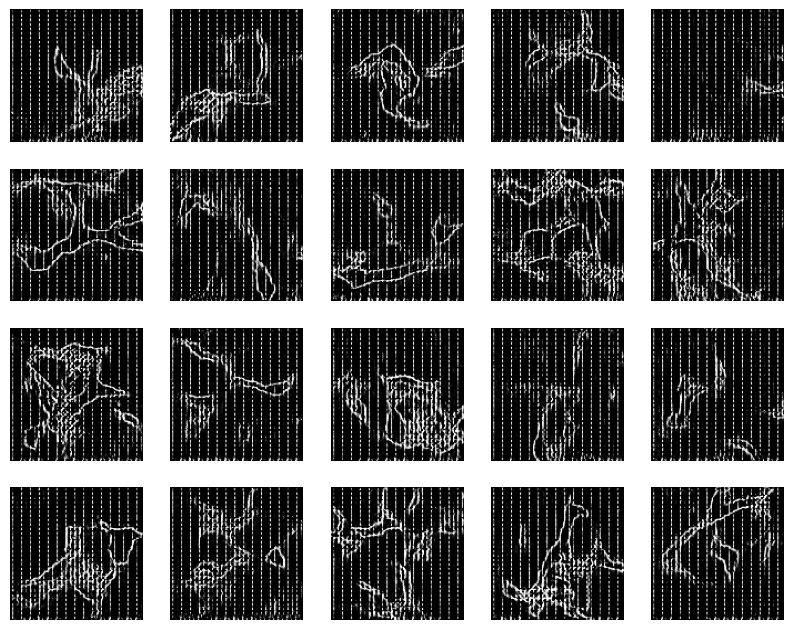

  0%|▏                                                                             | 12/5000 [00:51<5:27:56,  3.94s/it]

Epoch 13/5000


  0%|▏                                                                             | 12/5000 [00:52<6:01:39,  4.35s/it]


KeyboardInterrupt: 

In [12]:
%%time 
train_dcgan(gan, train_dataset, batch_size, random_noise_size, epochs=5000)


test

(1, 120, 120, 1)
(120, 120, 1)


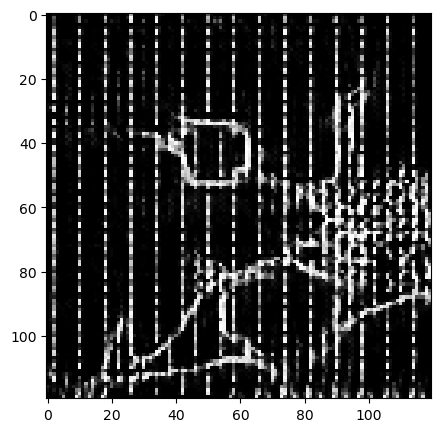

In [13]:
noise = tf.random.normal(shape=[1, random_noise_size])
generated_image = generator(noise)
generated_image = generated_image * 127.5 + 127.5
discriminator(generated_image)

print(generated_image.shape)
generated_image = tf.reshape(generated_image,(WIDTH,HEIGHT,CHANNEL))
print(generated_image.shape)
plt.figure(figsize=(5,5))
plt.imshow(generated_image[:,:,0],cmap="binary")